# Amazon Title Reviews Sentiment - Bidirectional LSTM

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
sns.set_style("darkgrid")
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re, string, nltk
!pip install emoji
import emoji, bz2
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Input, Embedding

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv("/content/Amazon_review.csv")
df.head()

,Unnamed: 0,review,sentiment
0,1959029,I just adopted a chocolate lab who loves to sn...,1
1,971879,Watched it and wasn't very impressed. It was t...,0
2,44681,"By 1967, enough was enough with the light fluf...",0
3,793119,I was interested in what all the hype was abou...,0
4,2921599,I expected a well written book (as someone rec...,0


In [ ]:
df = df[["review","sentiment"]]
df

,review,sentiment
0,I just adopted a chocolate lab who loves to sn...,1
1,Watched it and wasn't very impressed. It was t...,0
2,"By 1967, enough was enough with the light fluf...",0
3,I was interested in what all the hype was abou...,0
4,I expected a well written book (as someone rec...,0
...,...,...
100795,I purchased this product for my 1 year old twi...,0
100796,"When reading this book, you will probably find...",1
100797,This video has some really great tunes the muc...,1
100798,"I did finish the movie, but it was only rallyi...",0


In [ ]:
# shape of data
print(f"Data consists of {df.shape[0]} rows and {df.shape[1]} columns.")

Data consists of 100800 rows and 2 columns.


In [ ]:
# checking for null values
df.isna().sum()

,0
review,0
sentiment,0


In [ ]:
# dropping null values
df = df.dropna()

In [ ]:
# # checking for any duplicate in the data
# df.duplicated().sum()

In [ ]:
df1 = df
df1.shape

(100800, 2)

In [ ]:
df1.sentiment.value_counts()

,count
sentiment,
1,50515
0,50285


Text(0.5, 1.0, 'Countplot for Sentiment Labels')

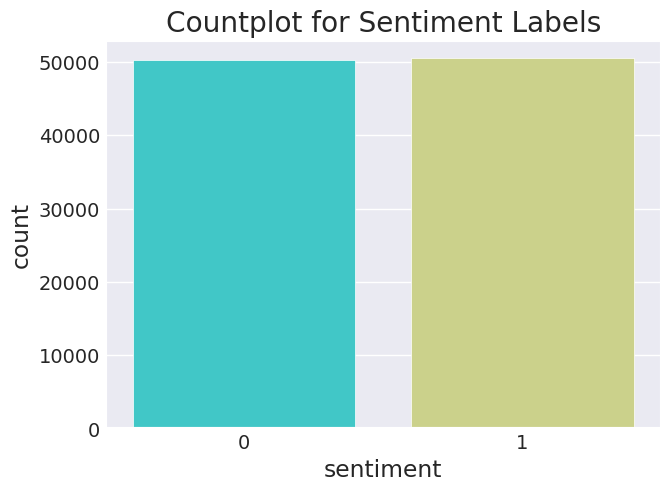

In [ ]:

sns.countplot(x=df1['sentiment'], palette="rainbow")
plt.title("Countplot for Sentiment Labels")

* Classes are balanced. So, no need for oversampling or undersampling the target column.

# Cleaning Data

In [ ]:
def clean_text(df, field):
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.replace("#[^a-zA-Z0-9_]+"," ")
    df[field] = df[field].str.replace(r"[^a-zA-Z(),\"'\n_]"," ")
    df[field] = df[field].str.replace(r"http\S+","")
    df[field] = df[field].str.lower()
    return df

clean_text(df1,"review")

,review,sentiment
0,i just adopted a chocolate lab who loves to sn...,1
1,watched it and wasn't very impressed. it was t...,0
2,"by 1967, enough was enough with the light fluf...",0
3,i was interested in what all the hype was abou...,0
4,i expected a well written book (as someone rec...,0
...,...,...
100795,i purchased this product for my 1 year old twi...,0
100796,"when reading this book, you will probably find...",1
100797,this video has some really great tunes the muc...,1
100798,"i did finish the movie, but it was only rallyi...",0


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Handle contractions
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)

    # Remove emojis
    text = emoji.demojize(text)
    text = re.sub(r":[a-z_]+:", "", text)  # Remove converted emoji text

    # Remove special characters (except spaces)
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)

    # Tokenization & Lemmatization
    text = [lemmatizer.lemmatize(word) for word in text.split() if word.lower() not in stop_words]

    return " ".join(text)

# Apply preprocessing to the 'review' column
df1["clean_review"] = df1["review"].apply(preprocess_text)

In [ ]:
df1.head()

,review,sentiment,clean_review
0,i just adopted a chocolate lab who loves to sn...,1,adopted chocolate lab love snuggle rub furnitu...
1,watched it and wasn't very impressed. it was t...,0,watched impressed taken 30 min less 70 tv show...
2,"by 1967, enough was enough with the light fluf...",0,1967 enough enough light fluff comedy starring...
3,i was interested in what all the hype was abou...,0,interested hype like book nicely banded pretty...
4,i expected a well written book (as someone rec...,0,expected well written book someone recommended...


Text(0, 0.5, 'Text Length')

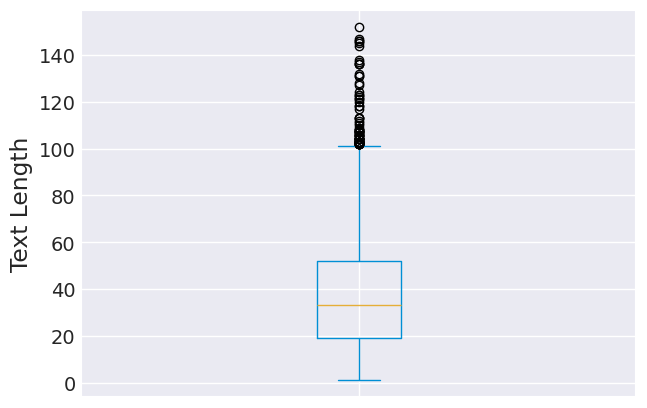

In [ ]:
text_length = pd.Series([len(review.split()) for review in df1["clean_review"]])
text_length.plot(kind="box")
plt.ylabel("Text Length")

Text(0, 0.5, 'Frequency')

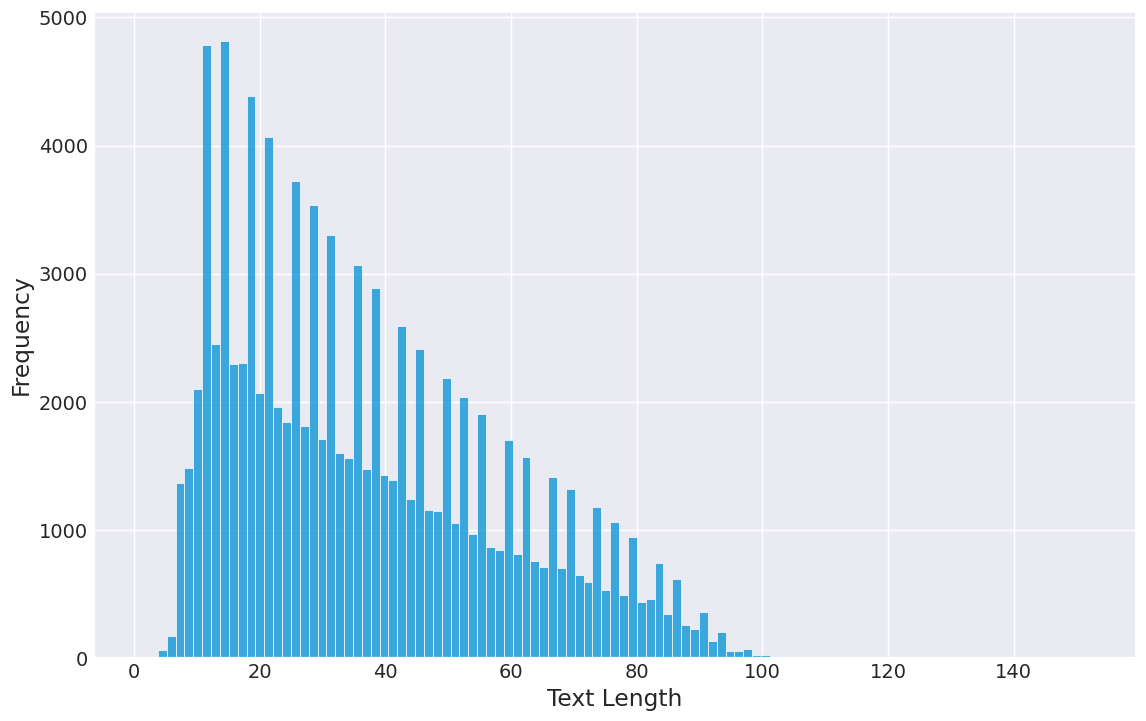

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(text_length,palette="deep")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

### WordClouds
* Useful for viewing and analyzing words that are frequently used.

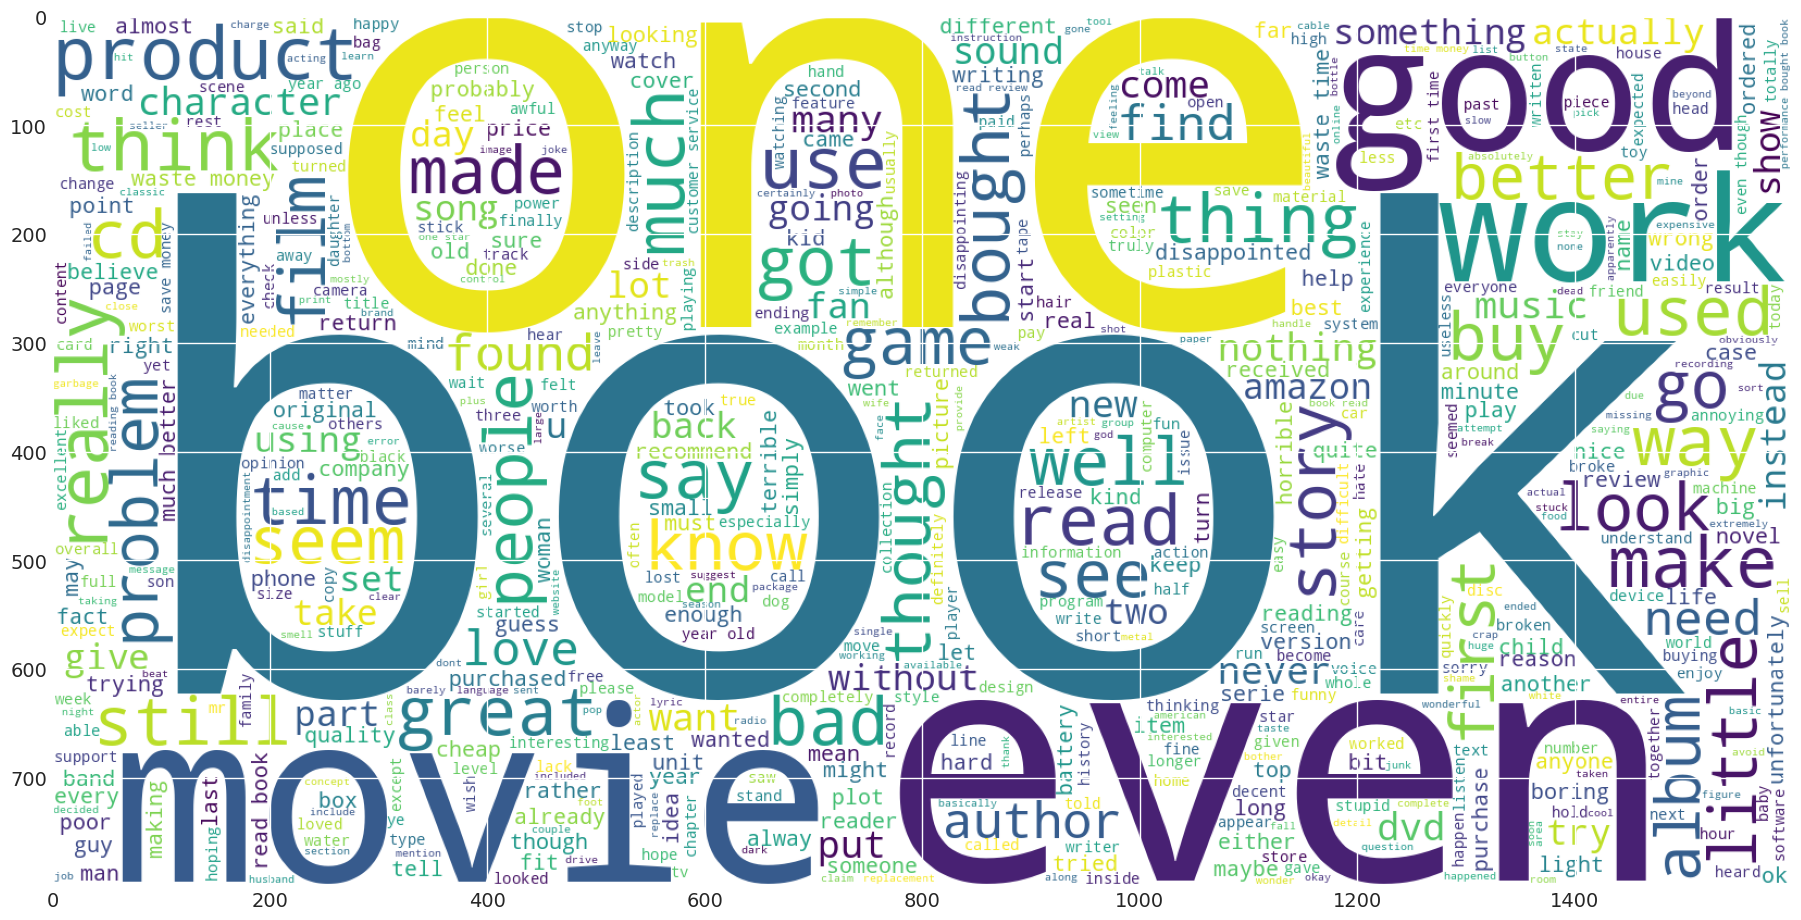

In [ ]:
# Negative Review WordCloud
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600,
               background_color="white").generate(" ".join(df[df["sentiment"]==0].clean_review))
plt.imshow(wc1)

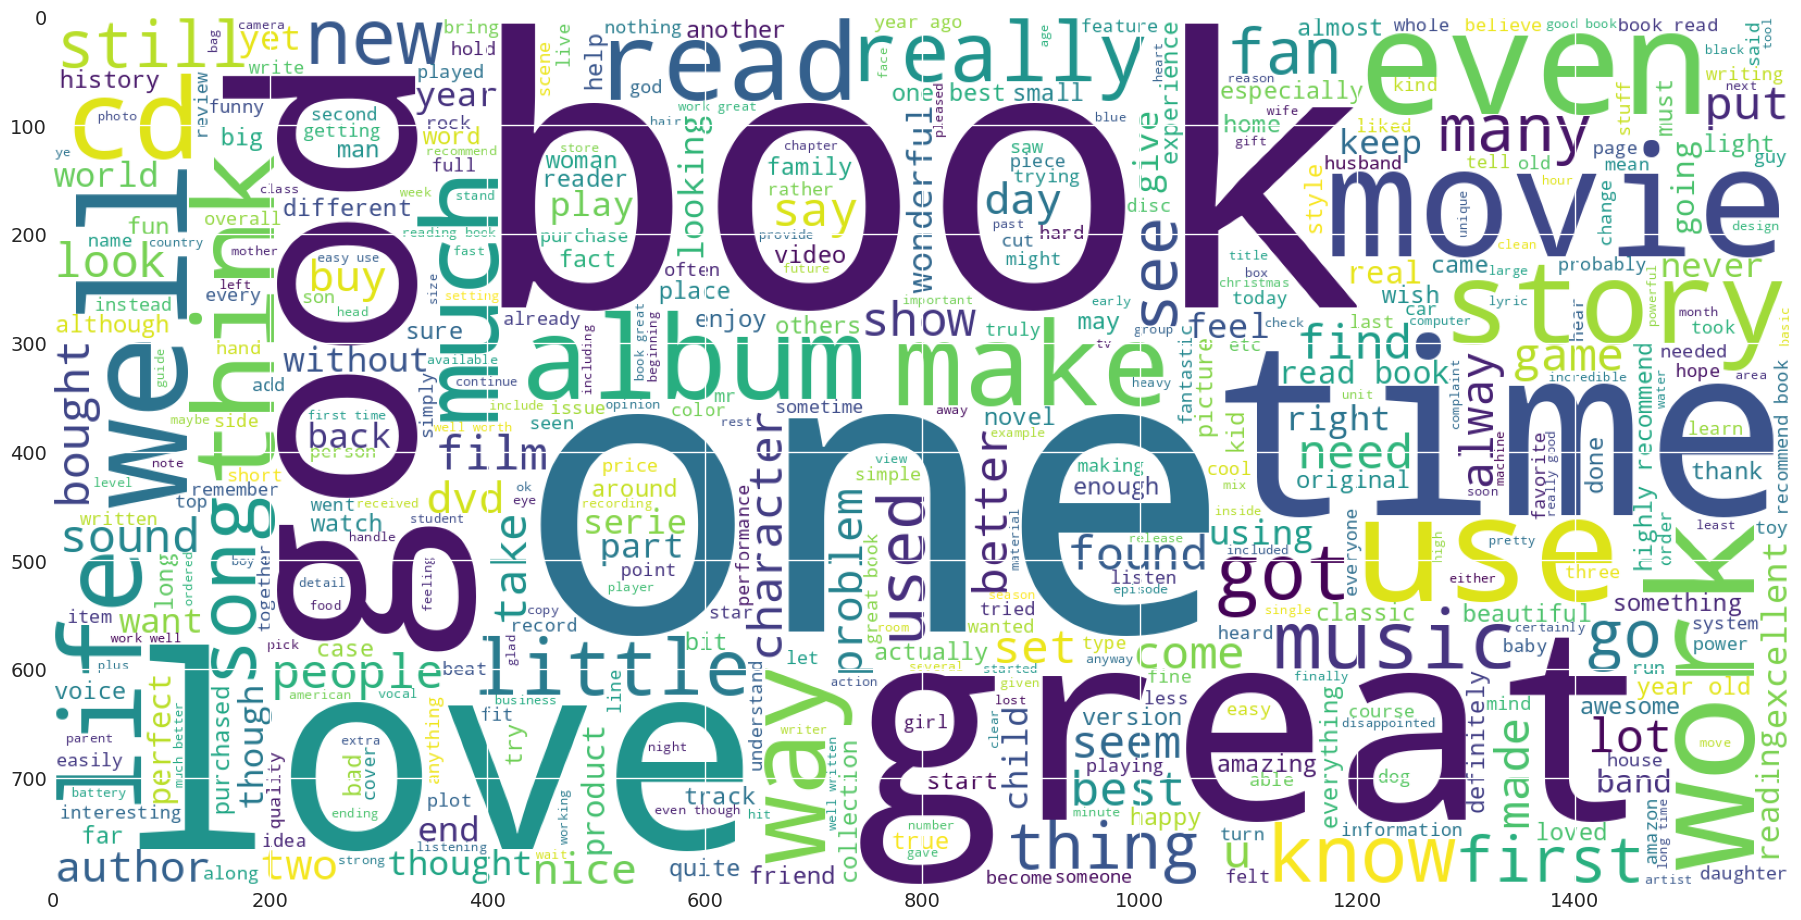

In [ ]:
# Positive Review WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600,
               background_color="white").generate(" ".join(df[df["sentiment"]==1].clean_review))
plt.imshow(wc)

In [ ]:
df = df1[["sentiment","clean_review"]]
df.head(10)

,sentiment,clean_review
0,1,adopted chocolate lab love snuggle rub furnitu...
1,0,watched impressed taken 30 min less 70 tv show...
2,0,1967 enough enough light fluff comedy starring...
3,0,interested hype like book nicely banded pretty...
4,0,expected well written book someone recommended...
5,1,great little feeder window simple basic design...
6,0,know everyone think exorcist best film ever ma...
7,0,twp favorite star clair dane jennifer lopez to...
8,0,item ordered birthday gift juneit september st...
9,0,product shipped good time dissappointed tea re...


In [ ]:
df.sentiment.unique()

array([1, 0])

# Model Training

In [ ]:
X = df["clean_review"].values
y = df["sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


X_train shape: (75600,), X_test shape: (25200,)


### Term Frequency- Inverse Document Frequency (TF-IDF)

In [ ]:
import nltk
nltk.download('punkt_tab')

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

tfidf2 = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize)
X_train_tf2 = tfidf2.fit_transform(X_train)
X_test_tf2 = tfidf2.transform(X_test)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf2 = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize)
# X_train_tf2 = tfidf2.fit_transform(X_train)
# X_test_tf2 = tfidf2.transform(X_test)

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


#### Fitting Machine learning Models

1) **Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tf2, y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred = rf.predict(X_test_tf2)
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_test, y_pred)
roc = roc_auc_score(y_test,y_pred)
print(f"Accuracy: {acc*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred)}")
print(report)

Accuracy: 83.02380952380952% and Roc Auc Score:0.8302213088416733
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     12618
           1       0.84      0.82      0.83     12582

    accuracy                           0.83     25200
   macro avg       0.83      0.83      0.83     25200
weighted avg       0.83      0.83      0.83     25200



2) **XGB Classifier**

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
xgb = XGBClassifier(eval_metric="mlogloss")
xgb.fit(X_train_tf2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred2 = xgb.predict(X_test_tf2)
acc2 = accuracy_score(y_pred2, y_test)
report2 = classification_report(y_test, y_pred2)
roc2 = roc_auc_score(y_test,y_pred2)
print(f"Accuracy: {acc2*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred2)}")
print(report2)

Accuracy: 82.0% and Roc Auc Score:0.820014598669249
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     12618
           1       0.81      0.83      0.82     12582

    accuracy                           0.82     25200
   macro avg       0.82      0.82      0.82     25200
weighted avg       0.82      0.82      0.82     25200



3) **LightGBM Classifier**

In [ ]:
lgb = LGBMClassifier()
lgb.fit(X_train_tf2, y_train)

[LightGBM] [Info] Number of positive: 37933, number of negative: 37667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 10.825858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 459232
[LightGBM] [Info] Number of data points in the train set: 75600, number of used features: 9174
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501759 -> initscore=0.007037
[LightGBM] [Info] Start training from score 0.007037


LGBMClassifier()

In [ ]:
y_pred_lgb = lgb.predict(X_test_tf2)
acc_lgb = accuracy_score(y_pred_lgb, y_test)
report_lgb = classification_report(y_test, y_pred_lgb)
roc_lgb = roc_auc_score(y_test,y_pred_lgb)
print(f"Accuracy: {acc_lgb*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred_lgb)}")
print(report_lgb)

Accuracy: 82.78571428571428% and Roc Auc Score:0.8278742518975662
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     12618
           1       0.82      0.84      0.83     12582

    accuracy                           0.83     25200
   macro avg       0.83      0.83      0.83     25200
weighted avg       0.83      0.83      0.83     25200



4) **Multinomial Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tf2, y_train)

MultinomialNB()

In [ ]:
y_pred3 = nb.predict(X_test_tf2)
acc3 = accuracy_score(y_pred3, y_test)
report3 = classification_report(y_test, y_pred3)
roc3 = roc_auc_score(y_test,y_pred3)
print(f"Accuracy: {acc3*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred3)}")
print(report3)

Accuracy: 81.8373015873016% and Roc Auc Score:0.8183469648804271
              precision    recall  f1-score   support

           0       0.81      0.84      0.82     12618
           1       0.83      0.80      0.81     12582

    accuracy                           0.82     25200
   macro avg       0.82      0.82      0.82     25200
weighted avg       0.82      0.82      0.82     25200



5) **Gradient Boosting Classifier**

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(X_train_tf2, y_train)

GradientBoostingClassifier()

In [ ]:
y_pred4 = gb.predict(X_test_tf2)
acc4 = accuracy_score(y_pred4, y_test)
report4 = classification_report(y_test, y_pred4)
roc4 = roc_auc_score(y_test,y_pred4)
print(f"Accuracy: {acc4*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred4)}")
print(report4)

Accuracy: 76.0436507936508% and Roc Auc Score:0.7603553499315532
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     12618
           1       0.79      0.70      0.75     12582

    accuracy                           0.76     25200
   macro avg       0.76      0.76      0.76     25200
weighted avg       0.76      0.76      0.76     25200



6) **Decision Tree Classifier**

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train_tf2, y_train)
y_pred5 = dt.predict(X_test_tf2)
acc5 = accuracy_score(y_pred5, y_test)
report5 = classification_report(y_test, y_pred5)
roc5 = roc_auc_score(y_test,y_pred5)
print(f"Accuracy: {acc5*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred5)}")
print(report5)

Accuracy: 70.85714285714285% and Roc Auc Score:0.7085811512994017
              precision    recall  f1-score   support

           0       0.71      0.70      0.71     12618
           1       0.71      0.72      0.71     12582

    accuracy                           0.71     25200
   macro avg       0.71      0.71      0.71     25200
weighted avg       0.71      0.71      0.71     25200



In [ ]:
from sklearn.metrics import precision_score
ps = precision_score(y_test, y_pred)
ps_lgb = precision_score(y_test,y_pred_lgb)
ps2 = precision_score(y_test, y_pred2)
ps3 = precision_score(y_test, y_pred3)
ps4 = precision_score(y_test, y_pred4)
ps5 = precision_score(y_test, y_pred5)

In [ ]:
accuracys = [acc,acc2,acc3,acc4,acc5,acc_lgb]
roc_scores = [roc, roc2, roc3, roc4,roc5, roc_lgb]
precision_scores = [ps,ps2,ps3,ps4,ps5,ps_lgb]
models = {"Random Forest":rf,"XGboost":xgb,"Naive Bayes":nb,"Gradient Boosting":gb,"Decision Tree":dt,"LGB Machine":lgb}

model_df = pd.DataFrame({"Models":models.keys(),"Accuracy":accuracys,"Precision Score":precision_scores,"Roc Scores": roc_scores}).sort_values("Roc Scores",ascending=False)

In [ ]:
# Summary of Machine Learning Models Performance
model_df

,Models,Accuracy,Precision Score,Roc Scores
0,Random Forest,0.830238,0.837781,0.830221
5,LGB Machine,0.827857,0.819783,0.827874
1,XGboost,0.820000,0.813171,0.820015
2,Naive Bayes,0.818373,0.829994,0.818347
3,Gradient Boosting,0.760437,0.793261,0.760355
4,Decision Tree,0.708571,0.705186,0.708581


Here, Random Forest gives the best accuracy compared to other models.